# MCMC Slice sampler in Python
### returns Markov chain and log-likelihoods
### D. Craig 2019 January 15 on SciServer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, normal

In [2]:
def slicer(g, dim, x0, xargs, N=1000, w=0.5, m=10):
    """MCMC slice sampler: 
            g -- function or distribution
            dim -- number of dimensions
            x0 -- initial guess (vector of parameters)
            xargs -- extra arguments for g (often data-related)
            N -- number of values in Markov chain to return 
            w -- step-out width for slice sampling
            m -- maximum for step-out scaling
        Returns: (xs, likelies)
            xs[N, dim] -- resulting Markov chain (includes initial guess as 0th)
            likelies[N] -- vector of log-likelihoods of chain
            
        See: Neal, "Slice Sampling," The Annals of Statistics 2003, vol. 31 (705-767). This is available online
        --D. Craig converted from Julia mslicer, 2019 Jan 15.
        """
    # based on Julia mslicer, version in mslicer-keeplikes.ipynb
    xs = np.zeros((N, dim), dtype=np.float64)    # array (Markov chain) that will be returned
    xs[0,:] = x0             #initial guess into the chain
    x1 = np.zeros(dim)
    L = np.zeros(dim)
    R = np.zeros(dim)
    likelies = np.zeros(N)     # record log likelihoods
    likelies[0] = g(x0,xargs)  # get log-like of initial guess; avoid fencepost error
    way = np.zeros(dim)  # which axis to go along in space
    i = 1    # assumed start values for chain are recorded at xs[0,:]; this will be index of first generated point 
    while i < N:
        for d in range(dim):     # go one step in each dimensional direction.
            way = 0.0 * way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing on this step
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0 + np.log(rand()) # height for slice (using log scaled distribution)
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - (w * way * U)
            R = L + w * way
            V = rand()
            J = np.floor(m*V)
            K = (m - 1) - J
            while J > 0 and y < g(L,xargs):
                L = L - w * way
                J = J - 1
            while K > 0 and y < g(R,xargs):
                R = R + w * way
                K = K - 1
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while True: 
                U = rand()
                x1 = Lbar + U * (Rbar - Lbar)  # vector subtraction should be correct dir
                if y < g(x1,xargs):
                    break # exit while loop
                if x1[d] < x0[d]:
                        Lbar = x1
                else: 
                        Rbar = x1
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            likelies[i] = y0 # record log-likelhood
            x0 = x1 # set initial to new point for next round.
            i += 1
            if i >= N:
                break # catch case where we reach N in the middle of set of dimensions
    return xs, likelies 

### Make the fake data, a linear + noise model

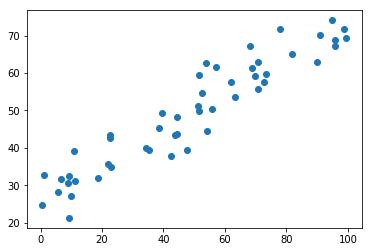

In [48]:
theta_true = [25.0,0.5] # [intercept slope]
xdata = 100*rand(50);
ydata = theta_true[0] + theta_true[1]*xdata
n = 5*normal(size=50)  # noise rms of 10
ydata += n
# ydata[j] += 40*normal(size=10) + 40  #contamination by gaussian of higher variance
plt.scatter(xdata, ydata);

In [49]:
def log_prior(theta):  #NOTE theta is a tuple
    """Jeffries prior for slopes"""
    alpha, beta, sigma = theta
    if sigma <= 0:
        return -np.inf   # log(0)
    else:
        return -0.5 * np.log(1 + beta**2) - np.log(sigma)  #Jeffreys prior for slopes

In [50]:
log_prior((24, .4, 5))

-1.683647914993237

In [77]:
def log_like(theta, xvec):
    alpha, beta, sigma = theta
    x = xvec[0]
    y = xvec[1]
    y_model = alpha + beta * x
    #return -0.5 * sum(np.log(2*np.pi*sigma**2) + (y - y_model)*(y - y_model) / sigma**2)
    return -0.5 * sum(np.log(2*np.pi*sigma**2) + (y - y_model)*(y - y_model) / sigma**2)

    #return y - y_model

In [78]:
def log_posterior(theta, xvec):
    return log_prior(theta) + log_like(theta,xvec)  #sum of logs is product in Bayes theorem numerator

## Execute; make the Markov chain:

In [79]:
%%time
res, likes = slicer(log_posterior, 3, [24.0, 0.5, 2.0], [xdata, ydata], N=5000);

CPU times: user 3.3 s, sys: 27.1 ms, total: 3.33 s
Wall time: 3.3 s


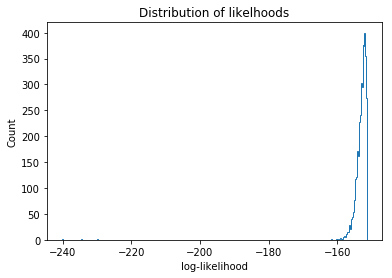

In [80]:
plt.hist(likes, bins="fd", histtype='step')
plt.title("Distribution of likelhoods");
plt.xlabel("log-likelihood")
plt.ylabel("Count");

In [83]:
A_chain = res[:,0]
B_chain = res[:,1]
N_chain = res[:,2]; # get the MCMC parameter chains out with convenient names 
                    # (marginalized samplings)

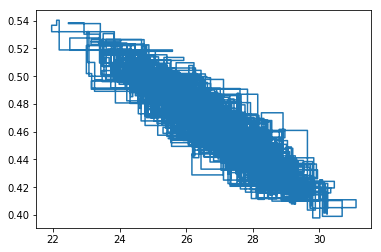

In [84]:
plt.plot(A_chain,B_chain);

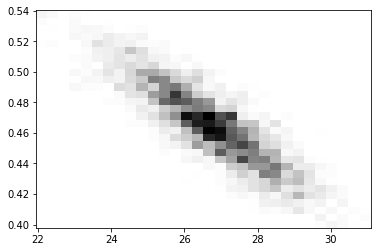

In [85]:
plt.hist2d(A_chain, B_chain, bins=30,cmap=plt.cm.Greys);

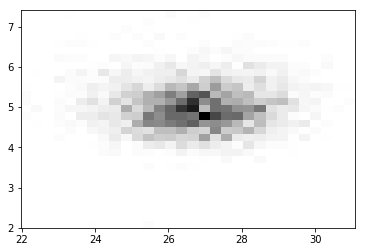

In [86]:
plt.hist2d(A_chain, N_chain, bins=30, cmap=plt.cm.Greys);

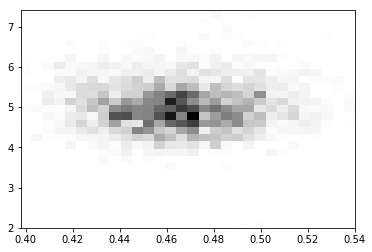

In [87]:
plt.hist2d(B_chain, N_chain, bins=30, cmap=plt.cm.Greys);

In [88]:
fit_idx = np.argmax(likes)

In [89]:
A_fit = res[fit_idx,0]
B_fit = res[fit_idx,1]
N_fit = res[fit_idx,2];

In [90]:
A_fit, B_fit, N_fit

(26.48159148615064, 0.4640067053708976, 4.805500772578093)

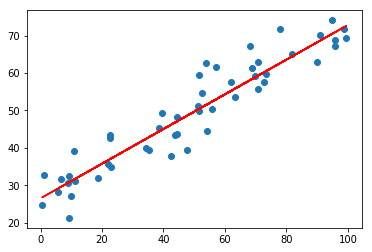

In [91]:
plt.scatter(xdata, ydata)
plt.plot(xdata, B_fit*xdata + A_fit, color='r');   # maximum likelihood model

--------------------------------------
## Background: slice sampling

Slice sampling is a Markov Chain Monte Carlo technique that tries to cut down on the amount of tuning needed to get a sample from the asymptotic distribution. Here I will try to explain it to myself.

Suppose we have a distribution (or something proportional to one): $ p(x) $. We pick a point $ x_0.$ Then we find a $ y_0 = p(x_0)$

<img src="slice-sampling-fig1.png" width=50%/>

Next, pick a point using a uniform random number generator on the interval $[0,y_0]$: this gives us $y$, 
$y = \text{Uniform}[0, y_0]$. $y$ defines a 'height' at the point $x_0$ that is below the probablility density. This also defines a _slice_ across $p(x)$ at height $y$, I'll call it $\cal{S}$. Now $\cal S$ is an interval, but of course we _don't_ know where it ends at either high or low values of $x$ yet.

<img src="slice-sampling-fig2.png" width=50%/>

Pick a width $w$, and let $L = x_0 - w$ and $R = x_0 + w.$ Next, grow the width until $L$ and $R$ lie _outside_ $\cal S$.  This can be detected by when both $p(L)$ and $p(R)$ are both _less_ than $y$: $p(L) < y \text{ and } p(R) < y.$

There are various choices for growing $w$ to find the edges of the slice: muliplicative, additive, etc.

Next, find a point in $\cal S$ by picking a point $x_1$ (randomly) in $[L,R]$ such that $ y < p(x_1)$ :

- if you fail, just try again with a new random number, until you hit it.
- if you miss, you can (carefully) shrink the interval until you get an acceptable point.

The point $x_1$ that is accepted will be a sample from the distribution.

See: Neal, "Slice Sampling," _The Annals of Statistics_ 2003, vol. 31 (705-767). This is available online.

In [19]:
?slicer